In [61]:
import numpy as np
from matplotlib import pyplot as plt
from scipy.ndimage import binary_fill_holes
from skimage.color import label2rgb
from skimage.filters._unsharp_mask import unsharp_mask
from skimage.filters.thresholding import threshold_triangle
from skimage.filters.thresholding import try_all_threshold
from skimage.measure import label, regionprops_table, find_contours
from skimage.morphology import binary_closing, disk
from skimage.morphology import binary_erosion, remove_small_objects
from skimage.morphology import binary_opening
from skimage.morphology import convex_hull_image, binary_dilation

from src.filters import normalize_0_255
from src.filters import sobel
from src.filters import yen_th
from src.fish.find_fish_props import refine_oversized_hull
from src.fish.is_fish import is_fish
from src.fish.remove_background import remove_background
from src.models import InputImage
from src.utils import keep_largest_object
from src.well.find_well_props import find_well_props

# Init input image & find well

In [62]:
input_img = InputImage("zf4.jpg")
input_img.processed = normalize_0_255(input_img.processed)
input_img.processed = np.uint8(input_img.processed)
input_img = find_well_props(input_img)

# Searching well properties
_____________________________________________________________
# Hough-transformation for the well
_____________________________________________________________
# Hough-transformation finished
_____________________________________________________________
# Creating mask for well
_____________________________________________________________


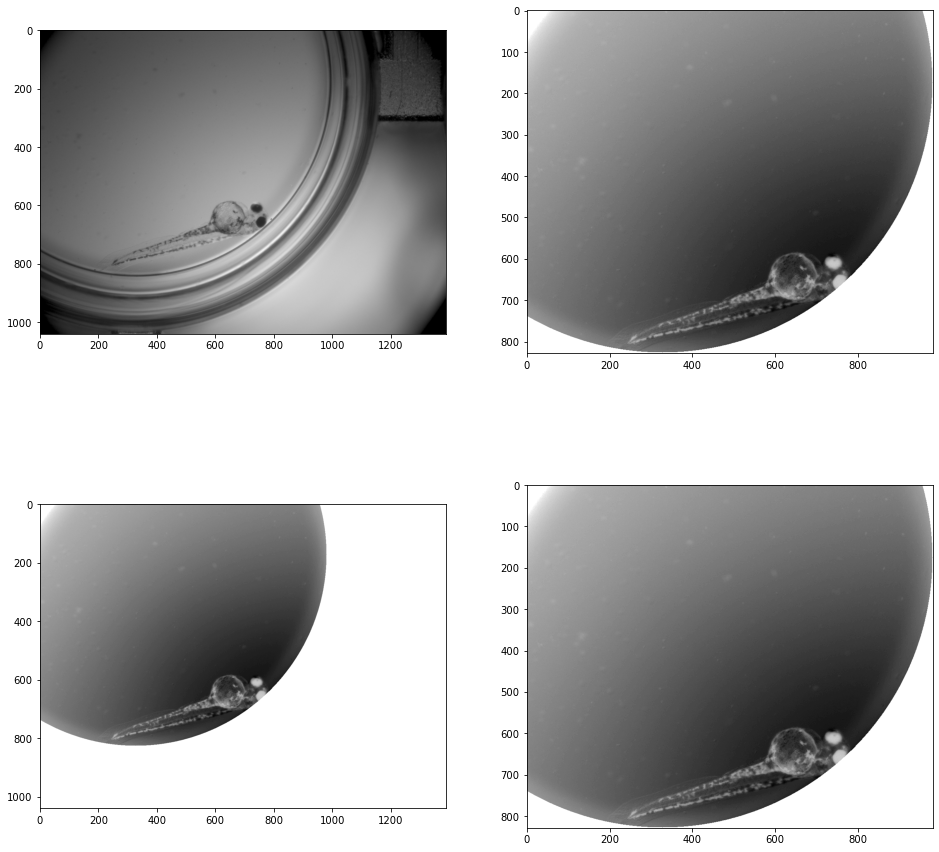

In [63]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(16, 16))
ax = ax.ravel()

ax[0].imshow(input_img.og, 'binary')
ax[1].imshow(input_img.processed, 'binary')
ax[2].imshow(input_img.well_props.mask.masked, 'binary')
ax[3].imshow(input_img.well_props.mask.cropped_masked, 'binary')

# Removing background

# Removing background
_____________________________________________________________


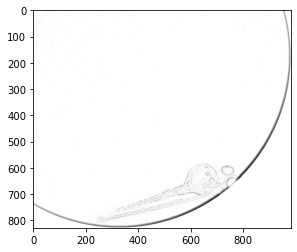

In [64]:
input_img.processed = input_img.well_props.mask.cropped_masked

input_img = remove_background(input_img)
r_bg = input_img.processed
plt.imshow(input_img.processed, 'binary')

In [65]:
# try_all_threshold(r_bg, figsize=(16,16), verbose=False)

# Triangle thresholding

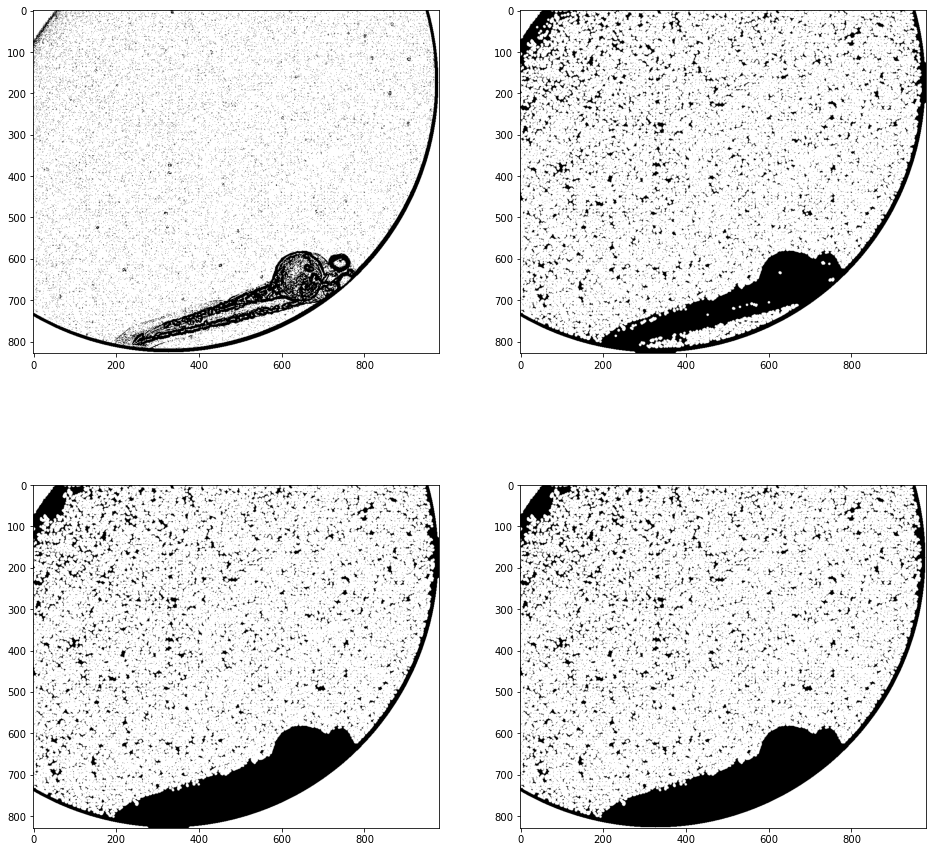

In [66]:
th = threshold_triangle(r_bg) < r_bg

closed = binary_closing(th, disk(3))
filled = binary_fill_holes(closed)
filled_masked = filled * input_img.well_props.mask.cropped

fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(16, 16))
ax = ax.ravel()

ax[0].imshow(th, 'binary')
ax[1].imshow(closed, 'binary')
ax[2].imshow(filled, 'binary')
ax[3].imshow(filled_masked, 'binary')

input_img.processed = filled_masked

# Convex hull & convex hull refinement

# Finding largest object
_____________________________________________________________
# Finding largest object
_____________________________________________________________
NOT FISH!
Too big! object / well = 0.44738942193596304
# Refining convex hull of fish, step #1
_____________________________________________________________
# Finding largest object's convex hull
_____________________________________________________________
# Finding largest object
_____________________________________________________________
IS FISH!


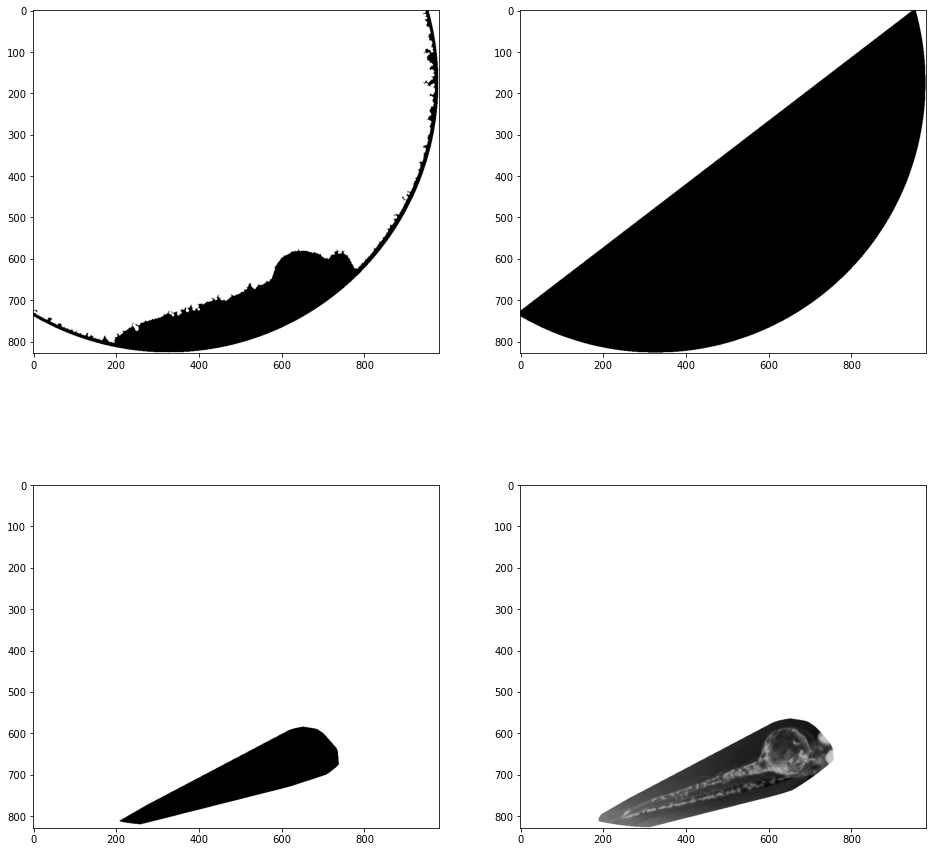

In [67]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(16, 16))
ax = ax.ravel()

klo = keep_largest_object(filled_masked)
fish_mask = convex_hull_image(klo).astype(float)

input_img.fish_props.mask.og = fish_mask

for i in range(6):
    if is_fish(input_img.fish_props.mask.og):
        break
    input_img = refine_oversized_hull(input_img, step=i + 1)

dilated_mask = binary_dilation(input_img.fish_props.mask.og, disk(20))
input_img.fish_props.mask.masked = dilated_mask * input_img.well_props.mask.cropped_masked
dilated_masked = input_img.fish_props.mask.masked

ax[0].imshow(klo, 'binary')
ax[1].imshow(fish_mask, 'binary')
ax[2].imshow(input_img.fish_props.mask.og, 'binary')
ax[3].imshow(dilated_masked, 'binary')

# Refine fish mask

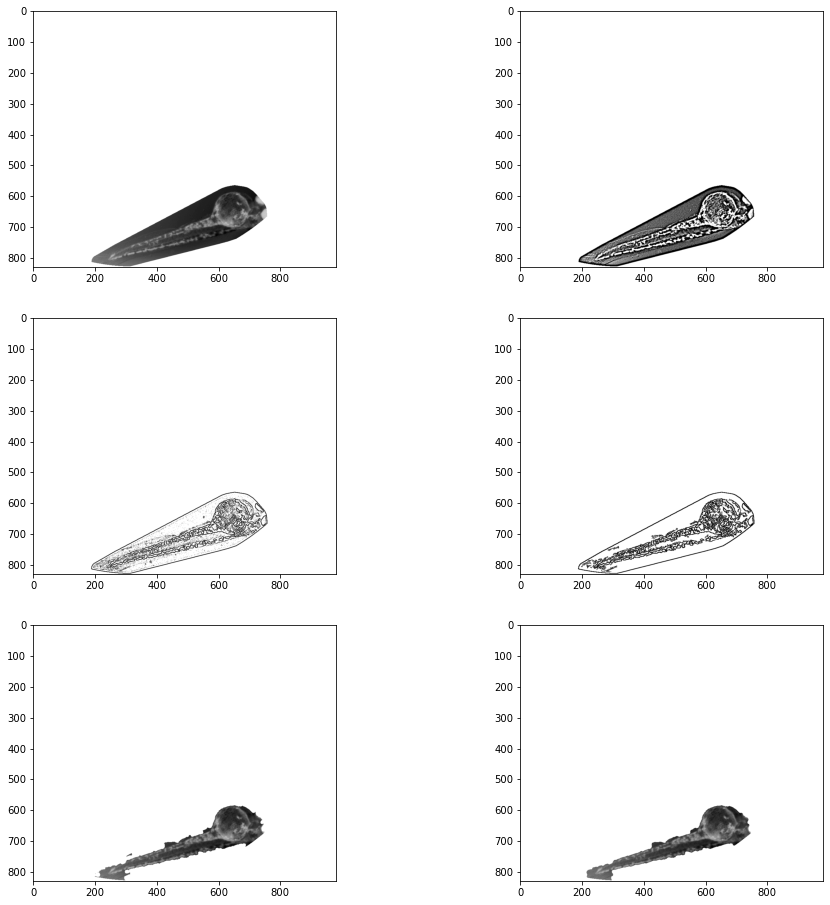

In [69]:
fig, ax = plt.subplots(nrows=3, ncols=2, figsize=(16, 16))
ax = ax.ravel()

um = unsharp_mask(dilated_masked, amount=20, radius=3)
sobe = sobel(um)

eroded_mask = binary_erosion(input_img.fish_props.mask.og, disk(5))

refined = remove_small_objects(yen_th(sobe))

refine = binary_fill_holes(binary_closing(refined * binary_erosion(dilated_mask, disk(10)), disk(5)))

fishy = refine * input_img.well_props.mask.cropped_masked
fishy_ = remove_small_objects(binary_opening(refine, disk(5))) * input_img.well_props.mask.cropped_masked

ax[0].imshow(dilated_masked, 'binary')
ax[1].imshow(um, 'binary')
ax[2].imshow(sobe, 'binary')
ax[3].imshow(refined, 'binary')
ax[4].imshow(fishy, 'binary')
ax[5].imshow(fishy_, 'binary')

# Finding largest object
_____________________________________________________________
# Finding largest object
_____________________________________________________________


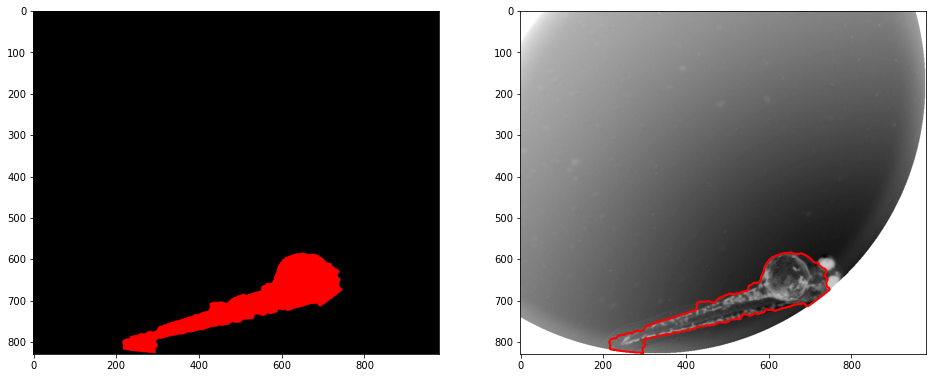

In [72]:
#labeled = label(input_img.fish_props.mask.og * binary_closing(fishy, disk(5)))
labeled = label(fishy_.astype(bool))
props = regionprops_table(labeled, properties=('label', 'bbox', 'area'))

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 16))
ax = ax.ravel()

largest_label = keep_largest_object(labeled)
hull = convex_hull_image(keep_largest_object(labeled))
hull = binary_dilation(hull, disk(5))

contour = find_contours(largest_label)


ax[0].imshow(label2rgb(labeled))
ax[1].imshow(input_img.well_props.mask.cropped_masked, 'binary')

for cont in contour:
    ax[1].plot(cont[:, 1], cont[:, 0], linewidth=2, color='red')